In [61]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import seaborn as sns 
import matplotlib.pyplot as plt

import gensim
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import cross_val_score , GridSearchCV,train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier

from gensim.models import Word2Vec
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from smart_open import smart_open
from numpy import random

%matplotlib inline

In [62]:
df = pd.read_csv("..//data//Womens Clothing E-Commerce Reviews Sentiment v2.csv")

In [63]:
def renames(feature, values):
    Dict_cols={}
    for value in values:
        Dict_cols[value]=feature+value
    return Dict_cols

In [64]:
## Encoding a categorical column
column_name='Division Name'
dummies= pd.get_dummies(df[column_name])
df=pd.concat([df,dummies], axis=1,ignore_index=False)
Division_columns=renames(column_name+'_',dummies.columns.tolist())
df=df.rename(index=str, columns=Division_columns)

column_name='Department Name'
dummies= pd.get_dummies(df[column_name])
df=pd.concat([df,dummies], axis=1,ignore_index=False)
Department_columns=renames(column_name+'_',dummies.columns.tolist())
df=df.rename(index=str, columns=Department_columns)

column_name='Class Name'
dummies= pd.get_dummies(df[column_name])
df=pd.concat([df,dummies], axis=1,ignore_index=False)
Class_columns=renames(column_name+'_',dummies.columns.tolist())
df=df.rename(index=str, columns=Class_columns)

Index(['Division Name_General', 'Division Name_General Petite',
       'Division Name_Initmates'],
      dtype='object')

In [67]:
df.columns

Index(['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name', 'processed_Review_text', 'PA_Polarity',
       'PA_Subjectivity', 'Division Name_General',
       'Division Name_General Petite', 'Division Name_Initmates',
       'Department Name_Bottoms', 'Department Name_Dresses',
       'Department Name_Intimate', 'Department Name_Jackets',
       'Department Name_Tops', 'Department Name_Trend', 'Class Name_Blouses',
       'Class Name_Casual bottoms', 'Class Name_Chemises',
       'Class Name_Dresses', 'Class Name_Fine gauge', 'Class Name_Intimates',
       'Class Name_Jackets', 'Class Name_Jeans', 'Class Name_Knits',
       'Class Name_Layering', 'Class Name_Legwear', 'Class Name_Lounge',
       'Class Name_Outerwear', 'Class Name_Pants', 'Class Name_Shorts',
       'Class Name_Skirts', 'Class Name_Sleep', 'Class Name_Sweaters',
       'Class Name_Swim', 'Class Name_Trend'],


In [42]:
## Discarding a empty reviews & removing the other columns

df=df[((df.processed_Review_text.isna()==False) & (df.processed_Review_text.isnull()==False) & (df.processed_Review_text!=""))]

In [43]:
# TF IDF Conversion
vectorizer = TfidfVectorizer()
review_vectors = vectorizer.fit_transform(df["processed_Review_text"])
features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())
review_columns= vectorizer.get_feature_names()

In [44]:
features_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df=pd.concat([df,features_df], axis=1,ignore_index=False)

In [45]:
df=df.drop(columns=['Clothing ID','Title','Division Name', 'Department Name', 'Class Name','Positive Feedback Count','Review Text','processed_Review_text'])

In [47]:
InputFeature=df.columns.tolist()
OutputFeature='Recommended IND'
InputFeature.remove(OutputFeature)

In [48]:
## For Hyper parameter selection used Grid Search

df.columns[df.columns.isin(list(Division_columns.values()))]

def param_selection(model,param_grid, nfolds=3):
#     print(str(datetime.datetime.now())+" : Starting Param selection")
    grid_search = GridSearchCV(model, param_grid, cv=nfolds,verbose =1)
    grid_search.fit( df[InputFeature], df[OutputFeature])
    print("Best Parmater for model : "+ str(grid_search.best_params_))
#     print(str(datetime.datetime.now())+" : Param selection is completed")
    return grid_search.best_estimator_

def Category_coefs(columnslist):
    # Coeffiencents
    coefs=pd.DataFrame({'Featrures':InputFeature, 'Coeff':modelbest_estimator.coef_[0]})
    ## Accounting both positive & negative important coefficients
    coefs=pd.concat([coefs.sort_values(by=['Coeff'],ascending=False).head(ImpFtrShow),coefs.sort_values(by=['Coeff'],ascending=False).tail(ImpFtrShow)])
    fig, ax = plt.subplots(figsize=(15,4))
    plt.bar(coefs['Featrures'], coefs['Coeff'])
    plt.xticks(rotation=40)
    plt.title('Top & Bottom '+str(ImpFtrShow)+' Features of Coeff''s ')


def model_experiment(model,param_grid, nfolds=[3,3], ImpFtrShow=8):
    ## Parameters ##
    ## model - Input model
    ## param_grid - model parameters in dict type to find best one, if no need to find - pass empty dict value
    ## nfolds - 1st value :GridSearchCV nfold value, 2nd value - Cross Validation nfold value. if you want to proceed with holdout validation, pass np.nan in 2nd parameter
    ## ImpFtrShow - Number of attribute to show
    
    datetime_start=datetime.datetime.now()
    
    print(str(datetime.datetime.now())+" : Starting the model experiments")
    if len(param_grid)==0:
        ## Spliting the train & test data
        X_train, X_test, y_train, y_test = train_test_split(df[InputFeature], df[OutputFeature],  test_size=0.2, random_state=0)
        
        # Fitting a model based on given parameter
        modelbest_estimator=model
        modelbest_estimator.fit(X_train,y_train)
        
        datetime_modelfit=datetime.datetime.now()
        minutes_diff = round((datetime_modelfit - datetime_start).total_seconds() / 60.0,2)
        print("Model Fitting completed in "+ str(minutes_diff) + " minutes ")
    else:
        ## Experimenting model with different parameters
        modelbest_estimator=param_selection(model,param_grid,nfolds[0])
        
        datetime_modelfit=datetime.datetime.now()
        minutes_diff = round((datetime_modelfit - datetime_start).total_seconds() / 60.0,2)
        print("Model GridSearch CV completed in "+ str(minutes_diff) + " minutes ")

    plt.subplots(figsize=(8,4))
    
    if np.isnan(nfolds[1]):
        y_pred = modelbest_estimator.predict(X_test)
        y=y_test
        print('Accuracy Score : '+str(metrics.accuracy_score(y,y_pred )))
        print('precision  : '+str(metrics.precision_score(y,y_pred ))) 
        print('recall  : '+str(metrics.recall_score(y,y_pred ))) 
        print('AUC  : '+str(metrics.roc_auc_score(y, y_pred)))
    else:
        ## Cross Validation 
        
        scores=cross_val_score(modelbest_estimator, df[InputFeature], df[OutputFeature], cv=nfolds[1], scoring="accuracy")
        plt.subplot(1,2,1)
        pd.Series(scores).plot(kind="box", label="Accuracy");
        plt.title('RMSE from 5 Folds')

        print("Cross Validation Accuracy Scores "+str(scores))
        print("Cross Validation Accuracy Mean Score "+str(np.mean(scores, dtype=np.float64)))
        
        scores=cross_val_score(modelbest_estimator, df[InputFeature], df[OutputFeature], cv=nfolds[1], scoring="roc_auc")
        print("Cross Validation Accuracy AUC Score "+str(np.mean(scores, dtype=np.float64)))

        datetime_cv=datetime.datetime.now()
        minutes_diff = round((datetime_modelfit - datetime_start).total_seconds() / 60.0,2)
        print("Model Cross Validation completed in "+ str(minutes_diff) + " minutes ")

        ## Validating the model
        y_pred = modelbest_estimator.predict(df[InputFeature])
        y=df[OutputFeature]
        
    ## Confusion Matrix 
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d',xticklabels=['No','Yes'], yticklabels=['No','Yes'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Coeffiencents
    coefs=pd.DataFrame({'Featrures':InputFeature, 'Coeff':modelbest_estimator.coef_[0]})
    ## Accounting both positive & negative important coefficients
    coefs=pd.concat([coefs.sort_values(by=['Coeff'],ascending=False).head(ImpFtrShow),coefs.sort_values(by=['Coeff'],ascending=False).tail(ImpFtrShow)])
    fig, ax = plt.subplots(figsize=(15,4))
    plt.bar(coefs['Featrures'], coefs['Coeff'])
    plt.xticks(rotation=40)
    plt.title('Top & Bottom '+str(ImpFtrShow)+' Features of Coeff''s ')

2019-08-22 18:27:54.784108 : Starting the model experiments
Model Fitting completed in 0.22 minutes 
Cross Validation Accuracy Scores [0.93997615 0.93904863 0.93600106]
Cross Validation Accuracy Mean Score 0.9383419460271188
Cross Validation Accuracy AUC Score 0.9788216860833533
Model Cross Validation completed in 0.22 minutes 


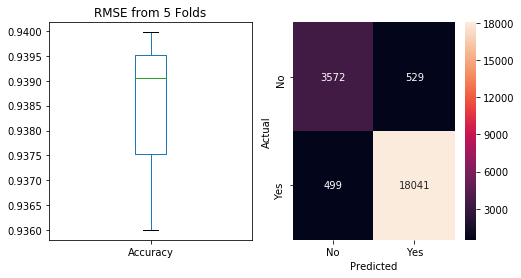

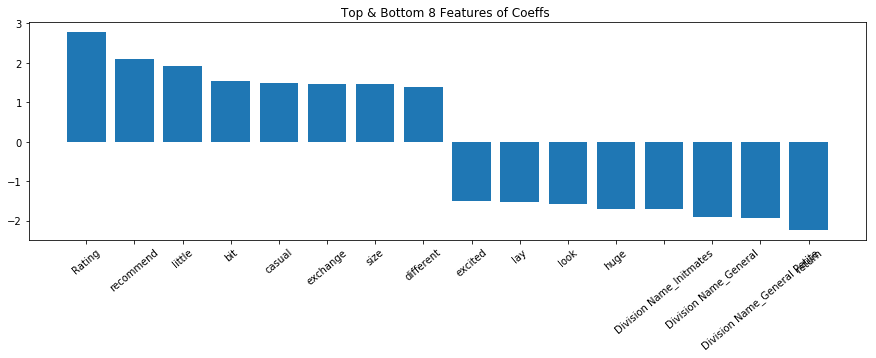

In [49]:
model=linear_model.LogisticRegression(n_jobs=1, solver='liblinear', C=1, penalty='l2', max_iter=1000)
param_grid={}#{'C':[0.01,1,100,1000]} 

model_experiment(model,param_grid,[3,3],8)

2019-08-22 18:29:09.009460 : Starting the model experiments
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  2.1min finished


Best Parmater for model : {'C': 1}
Model GridSearch CV completed in 2.32 minutes 
Cross Validation Accuracy Scores [0.93997615 0.93904863 0.93600106]
Cross Validation Accuracy Mean Score 0.9383419460271188
Cross Validation Accuracy AUC Score 0.9788216860833533
Model Cross Validation completed in 2.32 minutes 


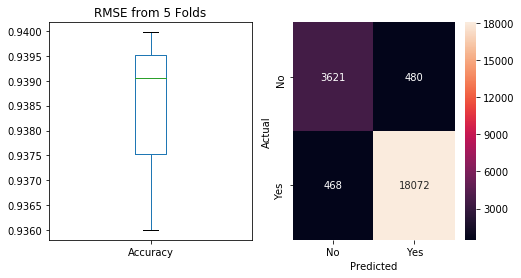

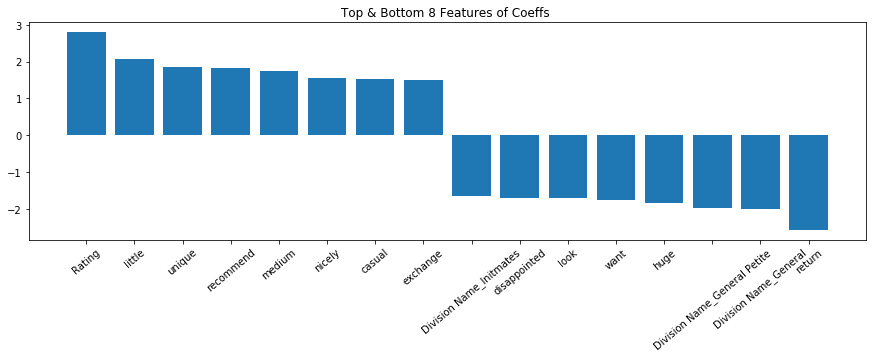

In [50]:
model=linear_model.LogisticRegression(n_jobs=1, solver='liblinear', penalty='l2', max_iter=1000)
param_grid={'C':[0.01,1,100,1000]} 

model_experiment(model,param_grid,[3,3])